# NIRSpec MSA reduction and spectral extraction

This notebook will run through the full JWST data reduction pipeline. It thus assumes that you have downloaded the uncal.fits files from MAST. For instructions on how to download all uncal.fits files in bulk, see [INSERT LINK HERE TO TEMPLATES GITHUB]. 

This notebook will focus on working with single-shutter MSA observations. I believe we are the first group to try this so lets hope it works! (Spoiler - it's working pretty well!)

Parts of this notebook are lifted from the TEMPLATES NIRSpec reduction notebook (soon to be published here: INSERT LINK TO TEMPLATES GITHUB). 

So far this has only been tested on the WHL0137 data, and I've been focused on the Sunrise Arc and Earendel. I'll try running this machinery on the MACS0647 soon (hopefully). 

### Things I've noticed so far:
The backgrounds do tend to vary a bit from shutter to shutter. So the general background subtraction applied here does not quite get everything - there are still some bakground signatures in many of the shutter spectra. For point sources, we can use the edges of the pipeline-created s2d spectra to estimate an additional "local" background. This seems to help when continuum shape is important. For line fluxes, continuum-subtraction solves the problem on its own. For extended sources where continuum is important, I don't quite know what to do yet. But we'll figure that out later!

In [1]:
import numpy as np
import glob
import os

# Modify the paths to the relevant directories on your machine
# ------------------------------------------------------------
# 1) point to where the jwst pipeline config files are located
home = "/Users/bdwelch1/Documents/" # for B. Welch
#home = "/Users/tahutch1/programs/jwst-drp/" # for T. Hutchison

# 2) point to where you keep your data
input_path = '/Users/bdwelch1/Documents/data/cosmic_spring/whl0137/nirspec/MAST_2022-12-27T0636/JWST/' # for B. Welch
#input_path = "/Users/tahutch1/data/raw/jwst/ers/templates/MAST_2022-09-23T1410/JWST/" # for T. Hutchison

# 3) point to where you want your processed outputs to live
output_path = '/Users/bdwelch1/Documents/data/cosmic_spring/whl0137/nirspec/pmap1027_code194/' # for B. Welch
#output_path = "/Users/tahutch1/data/raw/jwst/ers/templates/reduced/" # for T. Hutchison


###############################################
# IMPORTANT!! Make sure to use 'jwst-crds-pub'! 
# This will contain the most up to date reference files
###############################################
#os.environ["CRDS_PATH"] = home + "crds_cache/jwst_pub"
#os.environ["CRDS_SERVER_URL"] = "https://jwst-crds-pub.stsci.edu"
########
# okay, so the JWST reference file servers are weird and actually ops is ahead of pub
# so for now, we will use ops. This should (maybe?) change in the future
########
os.environ["CRDS_PATH"] = home + "crds_cache/jwst_ops"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"


import zipfile
import urllib.request

import json

from astropy.io import fits
from astropy.utils.data import download_file
import astropy.units as u
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch, AsinhStretch

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# The calwebb_spec and spec3 pipelines
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# the level1 pipeline:
from jwst.pipeline import Detector1Pipeline

# data models
from jwst import datamodels

# association file utilities
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

In [4]:
# The uncal files include science observations and target acquisition observations
# This cell just grabs all the uncal files, and lists which group/exposure numbers are science vs TA
# EXP_TYPE = NRS_MSASPEC are the science observations

files = glob.glob(input_path + '*nrs*/*_uncal.fits') #list the uncalibrated (level 1b) files.
files = sorted(files)

for exposure in files:
    test = fits.open(exposure)
    head = test[0].header
    print(head["EXP_TYPE"],head["VISITGRP"],head["EXPOSURE"])
print(len(files))

NRS_MSATA 03 1
NRS_MSATA 03 1
NRS_MSATA 03 2
NRS_MSATA 03 2
NRS_TACONFIRM 03 3
NRS_TACONFIRM 03 3
NRS_MSASPEC 06 1
NRS_MSASPEC 06 1
NRS_MSASPEC 08 1
NRS_MSASPEC 08 1
NRS_MSASPEC 10 1
NRS_MSASPEC 10 1
NRS_MSATA 02 1
NRS_MSATA 02 1
NRS_MSATA 02 2
NRS_MSATA 02 2
NRS_TACONFIRM 02 3
NRS_TACONFIRM 02 3
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSATA 02 1
NRS_MSATA 02 1
NRS_MSATA 02 2
NRS_MSATA 02 2
NRS_TACONFIRM 02 3
NRS_TACONFIRM 02 3
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
NRS_MSASPEC 04 1
36


In [ ]:
# checking that the file system is in place for these data
# if not, creating the folders
folders = ['L2a/', 'L2a/msa1', 'L2a/msa2', 'L2a/msa3']

for folder in folders:
    if os.path.exists(output_path + folder) == False: # if folder doesn't exist
        print('Creating folder ' + output_path + folder)
        os.system('mkdir ' + output_path + folder) # creates the folder


Now we can run the Level 1 pipeline! This can be kind of slow, but the two maximum_cores parameters below allow parallel processing in the two longest/slowest stages. max_cores = None is the default, uses only one core, and takes approximately a Hubble time to complete. Other options are "quarter", "half", and "all", which use 1/4, 1/2, and all available cores, respectively. "all" is the fastest, but makes doing anything else with your machine practically impossible. "half" is nearly as fast, but allows you to keep doing other stuff. So generally I stick with "half". 

In [ ]:
# Run the pipeline, splitting outputs into output folders based on MSA pointing/pattern (MSA1/2/3)
# DONT FORGET TO CHANGE THE TARGET NAMES FOR OTHER OBSERVATIONS!!!

for exposure in files: 
    det1 = Detector1Pipeline()
    # set output directory based on sci vs bkg exposure
    head = fits.open(exposure)[0].header
    if head['TARGPROP'] == 'WHL0137-MSA': 
        det1.output_dir = output_path + 'L2a/msa1'
    elif head['TARGPROP'] == 'WHL0137-MSA-OBS2':
        det1.output_dir = output_path + 'L2a/msa2'
    elif head['TARGPROP'] == 'WHL0137-MSA-OBS3':
        det1.output_dir = output_path + 'L2a/msa3'
    else: print('not target')
    # now we set other parameters:
    det1.save_results = True
    det1.jump.maximum_cores = 'half'
    det1.ramp_fit.maximum_cores = 'half'

    det1(exposure)


Now on to Stage 2!! This is where the background subtraction (magic) happens, so it gets a bit more complicated. I'll try to include many comments to make it clear what is happening. 

In [ ]:
# checking that the file system is in place for these data
# if not, creating the folders
folders = ['L2b/','L2b/msa1/','L2b/msa2/', 'L2b/msa3']

for folder in folders:
    if os.path.exists(output_path + folder) == False: # if folder doesn't exist
        print('Creating folder ' + output_path + folder)
        os.system('mkdir ' + output_path + folder) # creates the folder


In [ ]:
# define a list of desired background shutters!
# I made a DS9 region file with all the shutters (will be posted alongside this notebook). 
# Look at that to know whats what. 
# You can also define a range (e.g. 30000 < id < 40000) if you want to use more shutters
# Here, I'm using all the background shutters in the vicinity of the Sunrise Arc

bglist = [20188, 20186, 20181, #NORTH
         20175, 20171, 20161,
         20147, 20135, 20133, 
         20123, 20121, 20111, 
         20110, 20100, 30196, #END NORTH
         30167, 20297, 20295, #SOUTH
         20279, 20287, 20285,
         20257, 20249, 20238,
         20236, 20219, 20216,
         20214, 20206, 20204, 
         20201] #END SOUTH

In [ ]:
# Now we'll define some functions to help work with the MSA metadata files
# The first sets your chosen background slits to "background"
# the second resets everything to the way it was straight out of MAST

def select_bg(hdu, criterion, criterion_type='LIST'):
    '''
    user-supplied criterion applied to select background MSA shutters.
    cirterion_type takes a string, currently either "LIST" or "MINMAX"
    either a list of source_ids or a min(source_id) and max(source_id)
    '''
    data2 = hdu[2].data
    if criterion_type == "MINMAX":
        ix = (data2["source_id"] >= criterion[0]) & (data2["source_id"] < criterion[1])
    elif criterion_type == "LIST":
        ix = np.isin(data2["source_id"], criterion)
    
    data2["background"][ix] = 'Y'
    data2["primary_source"][ix] = 'N'
    

def reset_bg(hdu):
    '''
    reset all shutters to background=N, primary_source=Y
    '''
    data2 = hdu[2].data
    ix = data2["background"] == 'Y'
    data2["background"][ix] = 'N'
    data2["primary_source"][ix] = 'Y'

In [ ]:
# Define where the Stage 1 pipeline outputs live

ratedir1 = '/Users/bdwelch1/Documents/data/cosmic_spring/whl0137/nirspec/pmap1027_code194/L2a/msa1/'
ratedir2 = '/Users/bdwelch1/Documents/data/cosmic_spring/whl0137/nirspec/pmap1027_code194/L2a/msa2/'
ratedir3 = '/Users/bdwelch1/Documents/data/cosmic_spring/whl0137/nirspec/pmap1027_code194/L2a/msa3/'

In [ ]:
# set up the bg-labeled MSA metadata files

# I copied the original metadata files to separate _msa_bglabel.fits files for convenience. 
# you can also just edit the original files in place if you prefer (chaos)
msa_metafiles1 = glob.glob(ratedir1+'*msa_bglabel.fits')
msa_metafiles2 = glob.glob(ratedir2+'*msa_bglabel.fits')
msa_metafiles3 = glob.glob(ratedir3+'*msa_bglabel.fits')

for metafile in msa_metafiles1:
    with fits.open(metafile, 'update') as metahdu:
        reset_bg(metahdu) # first we reset everything, so we only get the background shutters we want
        select_bg(metahdu, bglist, "LIST") # now we select our background shutters. 

for metafile in msa_metafiles2:
    with fits.open(metafile, 'update') as metahdu:
        reset_bg(metahdu)
        select_bg(metahdu, bglist, "LIST")
        
for metafile in msa_metafiles3:
    with fits.open(metafile, 'update') as metahdu:
        reset_bg(metahdu)
        select_bg(metahdu, bglist, "LIST")


In [ ]:
# and now, the moment you've all been waiting for...
# We finally run the Level 2 pipeline!

for file in files_m1:
    with fits.open(file, 'update') as hdu:
        head = hdu[0].header
        if head["EXP_TYPE"] != "NRS_MSASPEC": continue # skip anything that isn't a science observation
        orig_metfl = head["MSAMETFL"]
        if 'bglabel' not in orig_metfl: # make sure we're using the bglabel msa metadata files defined above
            head["MSAMETFL"] = orig_metfl.split('.')[0] + '_bglabel.fits'
    spec2 = Spec2Pipeline()
    spec2.output_dir = output_path + 'L2b_bgsub/msa1'
    spec2.save_results = True
    spec2(file)

for file in files_m2:
    with fits.open(file, 'update') as hdu:
        head = hdu[0].header
        if head["EXP_TYPE"] != "NRS_MSASPEC": continue
        orig_metfl = head["MSAMETFL"]
        if 'bglabel' not in orig_metfl:
            head["MSAMETFL"] = orig_metfl.split('.')[0] + '_bglabel.fits'
    spec2 = Spec2Pipeline()
    spec2.output_dir = output_path + 'L2b_bgsub/msa2'
    spec2.save_results = True
    spec2(file)

for file in files_m3:
    with fits.open(file, 'update') as hdu:
        head = hdu[0].header
        if head["EXP_TYPE"] != "NRS_MSASPEC": continue
        orig_metfl = head["MSAMETFL"]
        if 'bglabel' not in orig_metfl:
            head["MSAMETFL"] = orig_metfl.split('.')[0] + '_bglabel.fits'
    spec2 = Spec2Pipeline()
    spec2.output_dir = output_path + 'L2b_bgsub/msa3'
    spec2.save_results = True
    spec2(file)


Next up - the Level 3 pipeline!!

This step takes longer than I expect every time. Be prepared to wait around a while.

In [ ]:
# BELOW COPIED FROM DAVID LAW'S MIRI MRS NOTEBOOK: 
# https://github.com/STScI-MIRI/MRS-ExampleNB/blob/main/Flight_Notebook1/MRS_FlightNB1.ipynb
# 
# Define a useful function to write out a Lvl3 association file from an input list
# Note that any background exposures have to be of type x1d.
def writel3asn(scifiles, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
        
    # Add background files to the association
    if bgfiles:
        nbg=len(bgfiles)
        for ii in range(0,nbg):
            asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [ ]:
# checking that the file system is in place for these data
# if not, creating the folders
folders = ['L3/']

for folder in folders:
    if os.path.exists(output_path + folder) == False: # if folder doesn't exist
        print('Creating folder ' + output_path + folder)
        os.system('mkdir ' + output_path + folder) # creates the folder

In [ ]:
l2outputpath = output_path + 'L2b/'
allmsa_calfiles = glob.glob(l2outputpath+'msa*/*cal.fits')

allmsa_asnfile = os.path.join(output_path, 'L3/L3asn.json')

writel3asn(allmsa_calfiles, None, allmsa_asnfile, 'WHL0137_Level3_AllMSA')
# the final string is what is prepended to the output files, so edit that to add descriptors if you'd like

In [ ]:
# And the final pipeline step: (this cell will take a while)
spec3 = Spec3Pipeline()
spec3.output_dir = output_path + 'L3/'
# Outlier detection is broken, so we skip it for now
spec3.outlier_detection.skip = True 
spec3.save_results = True # DON'T FORGET THIS OR YOU'LL WASTE SEVERAL HOURS FOR NAUGHT!

spec3.run(allmsa_asnfile)

## That's it for the pipeline!! 

Next up - lets take a look at the spectra and see what we've got!!

This is where we'll take a look at the background within the shutters. It'll be so much fun!

In [17]:
# First, lets define a couple convenience functions to extract the 1D spectrum by-hand and convert to Flambda units
import astropy.units as u
from astropy.nddata import StdDevUncertainty

from specutils.spectra import Spectrum1D

def extract1D(x1dfile, s2dfile, sourcepix_range, bgpix_range=None):
    '''
    Extract spectrum from s2d file, using wavelength solution from x1dfile
    perform local background subtraction if bgpix_range set to something
    extracts spectrum from sourcepix_range. Just sums flux in those pixels
    '''
    with fits.open(x1dfile) as xfile:
        wl = xfile[1].data["WAVELENGTH"]
    with fits.open(s2dfile) as sfile:
        s2dim = sfile[1].data
        s2derr = sfile[2].data
    
    sourcemin, sourcemax = sourcepix_range[0], sourcepix_range[1]
    source_flux = sum(s2dim[sourcemin:sourcemax,:]) * 1e6 # convert from native MJy to Jy
    source_err = np.sqrt(sum(s2derr[sourcemin:sourcemax,:]**2)) * 1e6
    
    if bgpix_range:
        bgmin, bgmax = bgpix_range[0], bgpix_range[1]
        bg_flux = sum(s2dim[bgmin:bgmax,:]) * 1e6 # convert from Mjy to Jy
        bg_err = np.sqrt(sum(s2dim[bgmin:bgmax,:]**2)) * 1e6
        source_flux -= bg_flux
        source_err = np.sqrt(source_err**2 + bg_err**2)
    
    return source_flux, source_err, wl


def convert_to_cgs(source_flux, source_err, wl):
    '''
    Assumes using output from extract1D
    which would be flux in Jy, wl in micron
    convert flux to erg/s/cm2/A
    convert wl to Angstrom
    return a specutils Spectrum1D object to use with bw_specstuff functions
    '''
    cgs = u.erg * u.cm**-2 * u.s**-1 * u.AA**-1

    flux_units = source_flux * u.Jy
    err_units = source_err * u.Jy
    wl_micron = wl * u.um

    flux_cgs = flux_units.to(cgs, equivalencies=u.spectral_density(wl_micron))
    err_cgs = err_units.to(cgs, equivalencies=u.spectral_density(wl_micron))
    err_cgs = StdDevUncertainty(err_cgs)

    spec = Spectrum1D(flux=flux_cgs, spectral_axis=wl_micron, uncertainty = err_cgs)

    return spec


In [10]:
%matplotlib notebook

first, for context, lets look at a background shutter (not used in BG subtraction in pipeline)

note this is from a reduction with the old version of the pipeline code, so it may not be perfectly accurate. But it should be fine for illustrative purposes

Key point here - background subtraction does a pretty good job, but doesn't quite get all the flux.

Also - the background has a clear shape. If we see that shape later on, we know the background was not fully subtracted

Last comment, the two large spikes are hot pixels (if its just 1 pixel, thats junk)


<IPython.core.display.Javascript object>


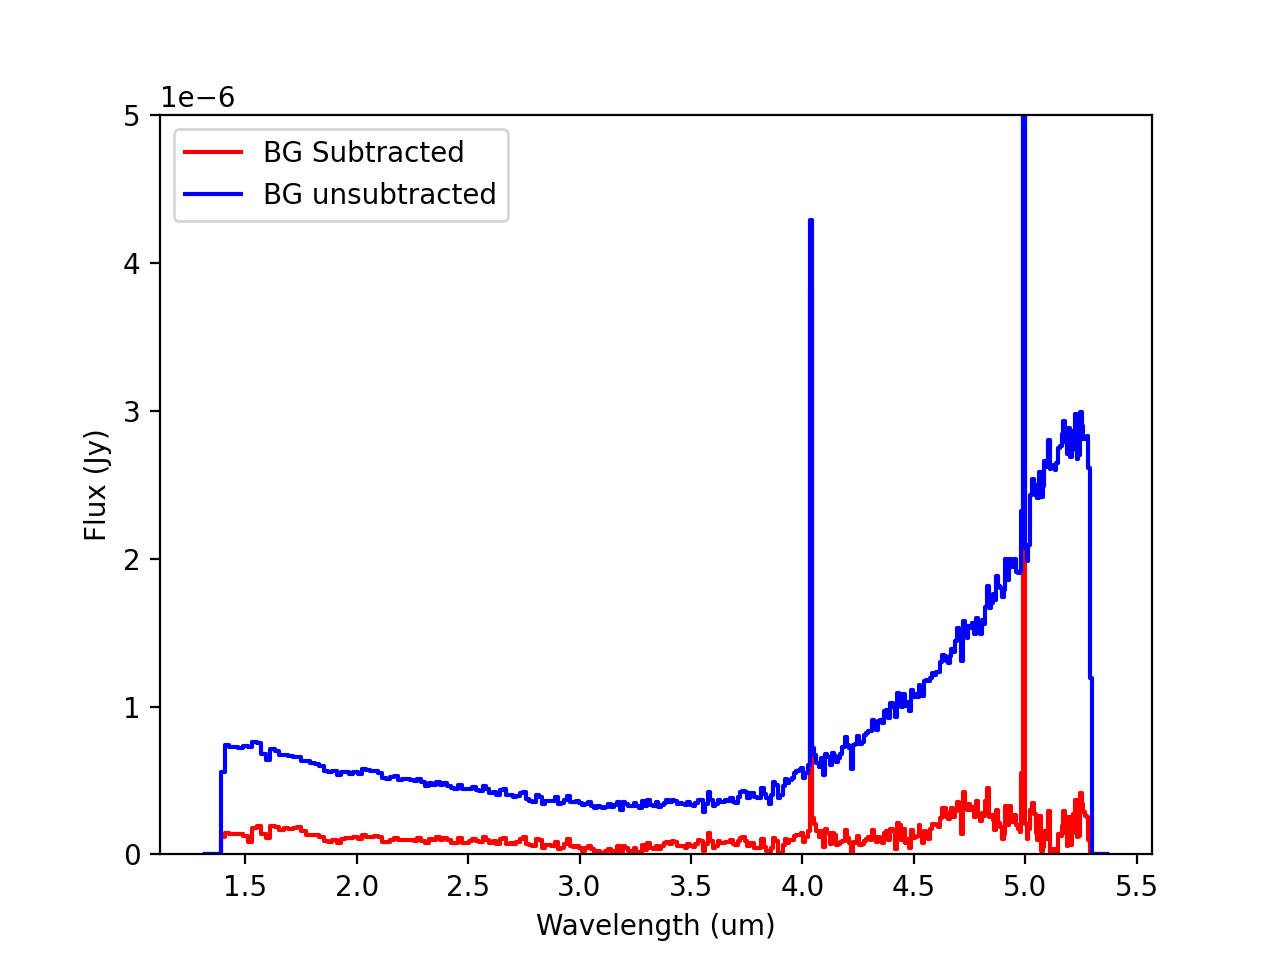

In [13]:
input_path = '/Users/bdwelch1/Documents/data/cosmic_spring/whl0137/nirspec/pmap1027/'

x1dfile = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s30225_x1d.fits')
s2dfile = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s30225_s2d.fits')
bg_flux1, bg_err1, bg_wl1 = extract1D(x1dfile, s2dfile, (0,4), None)

x1dfile = os.path.join(input_path, 'L3/WHL0137_Level3_AllMSA_s30225_x1d.fits')
s2dfile = os.path.join(input_path, 'L3', 'WHL0137_Level3_AllMSA_s30225_s2d.fits')
bg_flux2, bg_err2, bg_wl2 = extract1D(x1dfile, s2dfile, (0,4), None)

fig = plt.figure()
plt.step(bg_wl1, bg_flux1, where='mid', color='r', label='BG Subtracted')
plt.step(bg_wl2, bg_flux2, where='mid', color='b', label='BG unsubtracted')
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux (Jy)')
plt.ylim(0,5e-6)
plt.legend()
plt.show()

So now we know what the background is supposed to look like. 

Next, lets take a look at the Earendel spectrum. We're going to try two things here - first, generic spectrum extraction just taking the pixels that show signs of flux from the source. Then we'll perform our local background subtraction, using pixels showing no sign of source flux. Finally, we'll plot the background pixels as well, to illustrate how the subtraction is happening. 

We'll show this one in both Fnu and Flambda units, just for fun. 

<IPython.core.display.Javascript object>


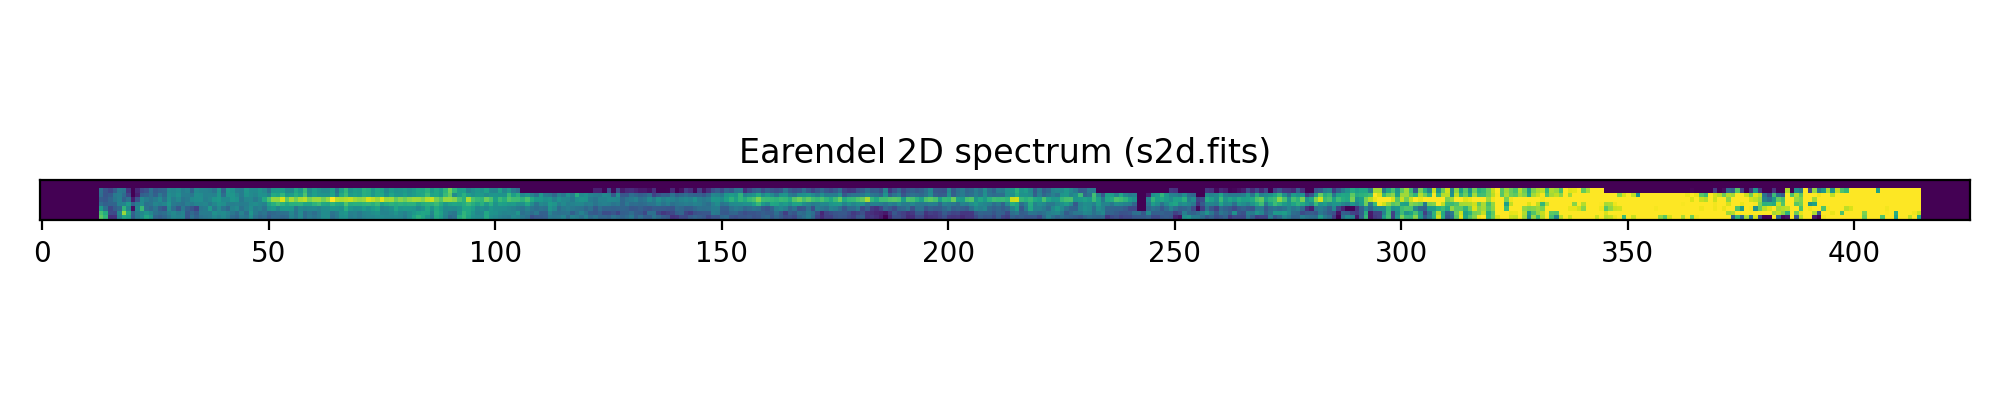

In [31]:
# lets look first at the s2d.fits image - the 2D extracted spectrum
input_path = '/Users/bdwelch1/Documents/data/cosmic_spring/whl0137/nirspec/pmap1027_code194/'

s2dfile = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s10000_s2d.fits')
with fits.open(s2dfile) as s2dhdu:
    shead10 = s2dhdu[0].header
    shead1 = s2dhdu[1].header
    s2dim = s2dhdu[1].data

fig, ax = plt.subplots(1,1,figsize=(10,2))

ax.imshow(s2dim, origin='lower', vmin=0, vmax=1e-13)
ax.set_yticks([])
ax.set_title('Earendel 2D spectrum (s2d.fits)')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


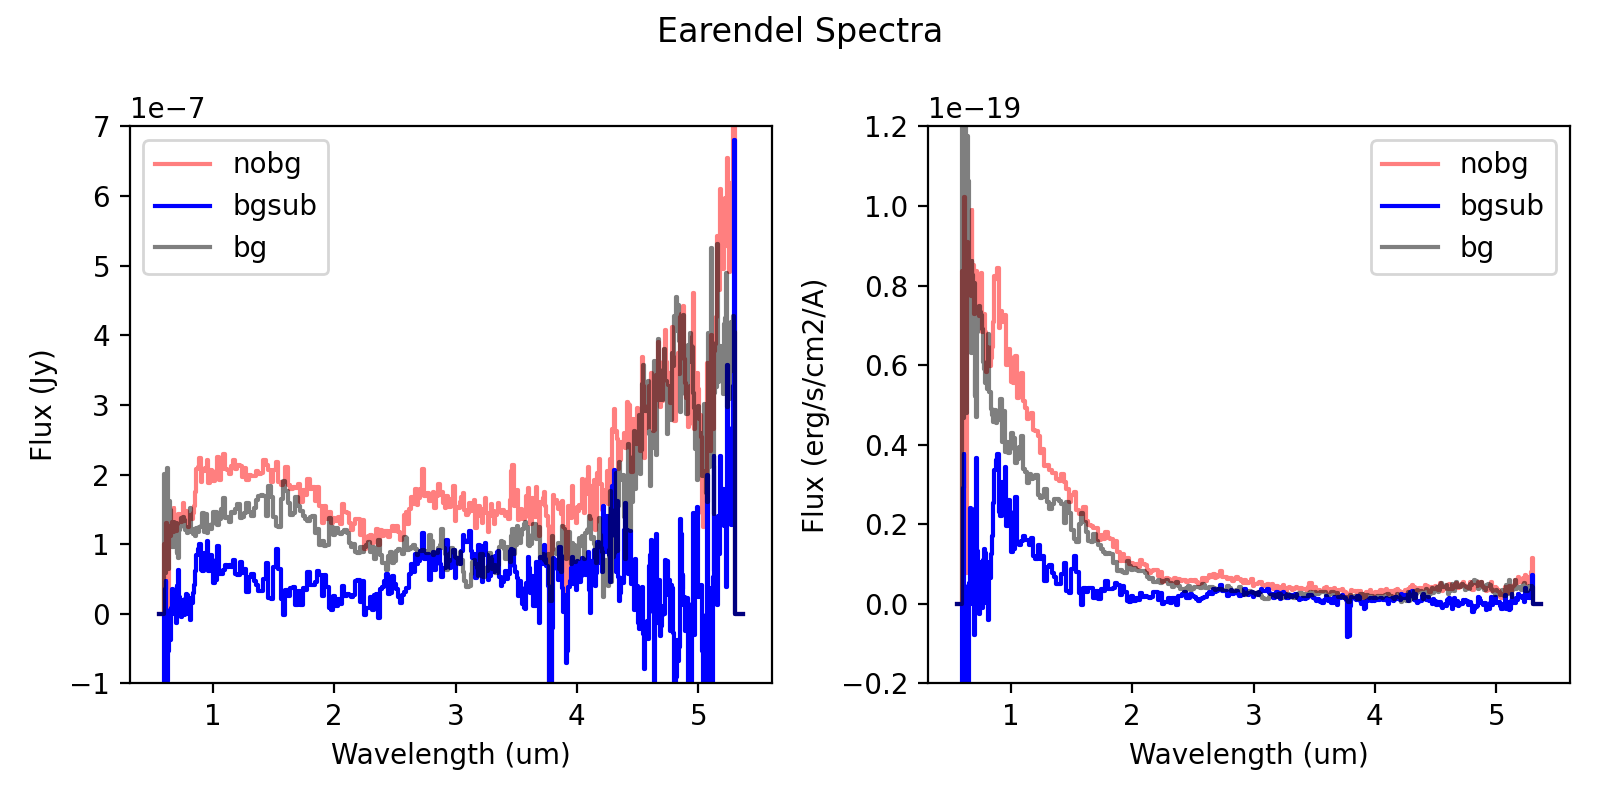

In [24]:
# first, the extraction without extra subtraction
x1dfile = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10000_x1d.fits')
s2dfile = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s10000_s2d.fits')
earendel_flux, earendel_err, earendel_wl = extract1D(x1dfile, s2dfile, (3,6), None)
starspec = convert_to_cgs(earendel_flux, earendel_err, earendel_wl)

# now the background subtracted version
x1dfile = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10000_x1d.fits')
s2dfile = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s10000_s2d.fits')
earendel_flux2, earendel_err2, earendel_wl2 = extract1D(x1dfile, s2dfile, (3,6), (0,3))
starspec2 = convert_to_cgs(earendel_flux2, earendel_err2, earendel_wl2)

# and the background alone:
earendel_fluxbg, earendel_errbg, earendel_wlbg = extract1D(x1dfile, s2dfile, (0,3), None)
starspec_bg = convert_to_cgs(earendel_fluxbg, earendel_errbg, earendel_wlbg)


fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].step(earendel_wl, earendel_flux, where='mid', label='nobg', alpha=0.5, color='r')
ax[0].step(earendel_wl2, earendel_flux2, where='mid', label='bgsub', color='b')
ax[0].step(earendel_wlbg, earendel_fluxbg, where='mid', label='bg', alpha=0.5, color='k')
ax[0].legend()
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_ylabel('Flux (Jy)')
ax[0].set_ylim(-1e-7, 7e-7)

ax[1].step(starspec.spectral_axis, starspec.flux, where='mid', color='r', alpha=0.5, label='nobg')
ax[1].step(starspec2.spectral_axis, starspec2.flux, where='mid', color='b', label='bgsub')
ax[1].step(starspec_bg.spectral_axis, starspec_bg.flux, where='mid', color='k', alpha=0.5, label='bg')
ax[1].legend()
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_ylabel('Flux (erg/s/cm2/A)')
ax[1].set_ylim(-2e-20, 1.2e-19)

fig.suptitle('Earendel Spectra')

plt.tight_layout()
plt.show()

So there is clearly a bit of leftover background in this shutter, which is particularly visible above ~4 micron and below ~0.8 micron (below the Ly-alpha break). This local background subtraction seems to remove that decently, though it may be oversubtracted at the long wavelength end. 

Next up, lets take a look at the spectra of clump 1a, 1b, and 2b! For clarity here, I'm just going to show the local-background-subtracted versions. Note here, the large spikes are not real emission lines, they are just hot pixels. Those will need to be masked out later. Also, these clumps each have ~half the integration time of Earendel, so they look a lot noisier. I'm working on a good way to stack the spectra, but that's not ready yet. 

<IPython.core.display.Javascript object>


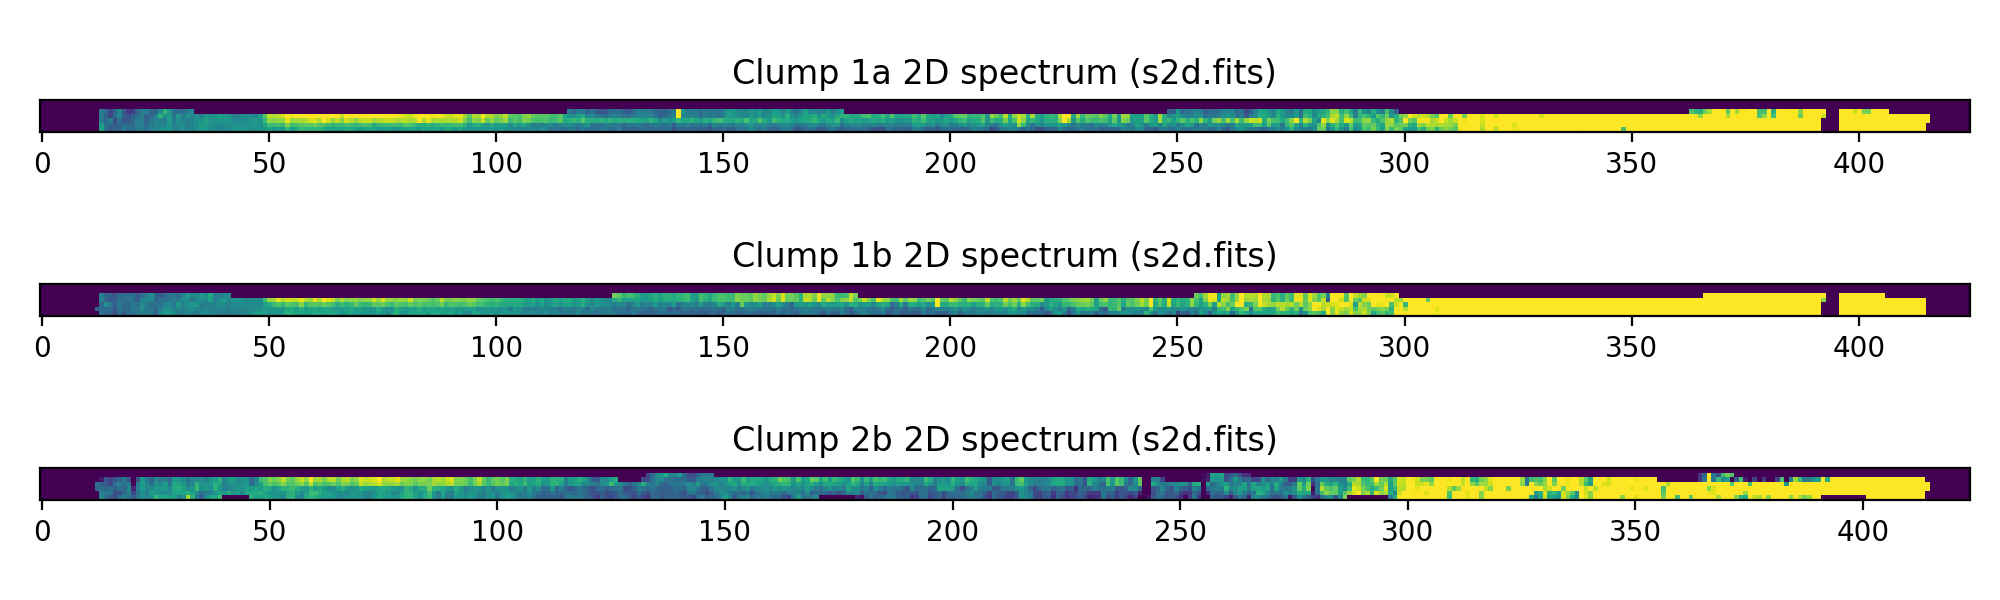

In [34]:
s2dfile_a = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s10001_s2d.fits')
with fits.open(s2dfile_a) as s2dhdu:
    s2dim_a = s2dhdu[1].data

s2dfile_b = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s10002_s2d.fits')
with fits.open(s2dfile_b) as s2dhdu:
    s2dim_b = s2dhdu[1].data

s2dfile_c = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s10020_s2d.fits')
with fits.open(s2dfile_c) as s2dhdu:
    s2dim_c = s2dhdu[1].data

fig, ax = plt.subplots(3,1,figsize=(10,3))

ax[0].imshow(s2dim_a, origin='lower', vmin=0, vmax=2e-13)
ax[0].set_yticks([])
ax[0].set_title('Clump 1a 2D spectrum (s2d.fits)')

ax[1].imshow(s2dim_b, origin='lower', vmin=0, vmax=2e-13)
ax[1].set_yticks([])
ax[1].set_title('Clump 1b 2D spectrum (s2d.fits)')

ax[2].imshow(s2dim_c, origin='lower', vmin=0, vmax=1e-13)
ax[2].set_yticks([])
ax[2].set_title('Clump 2b 2D spectrum (s2d.fits)')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


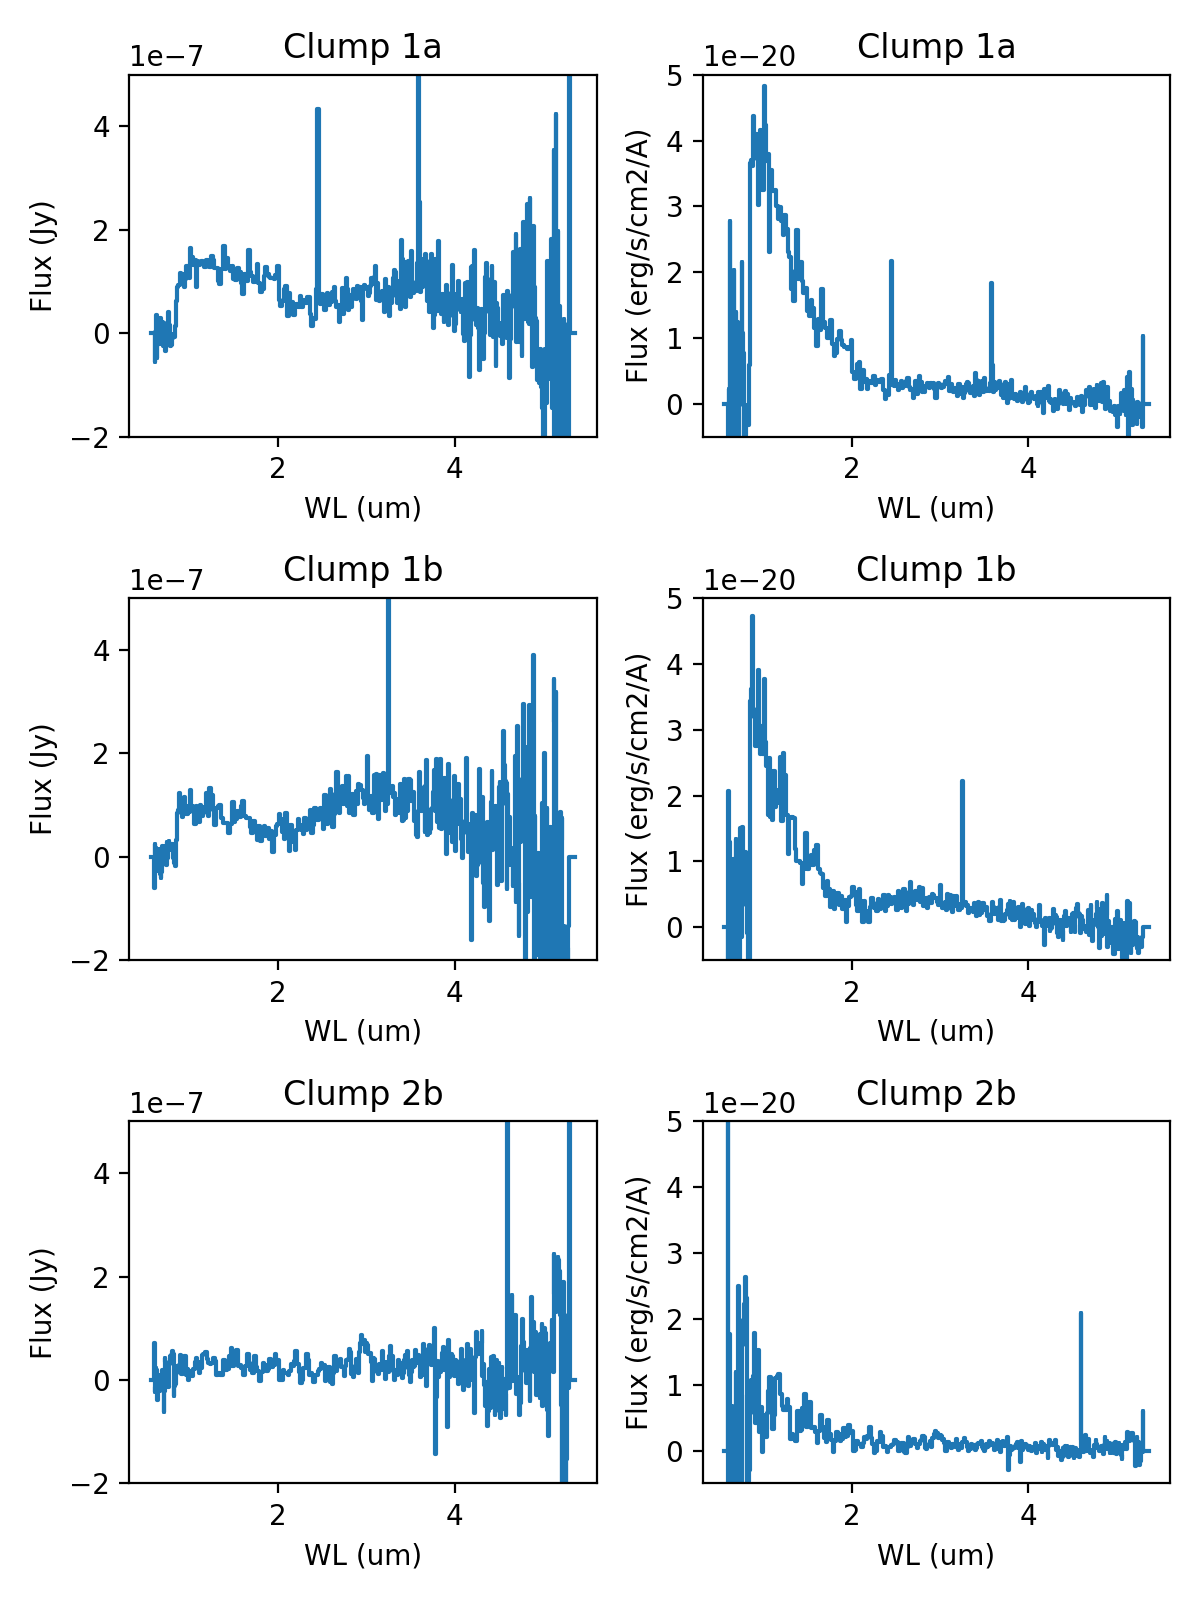

In [28]:
x1d10001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10001_x1d.fits')
s2d10001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10001_s2d.fits')
flux10001, err10001, wl10001 = extract1D(x1d10001, s2d10001, (2,4), (0,2))

spec10001 = convert_to_cgs(flux10001, err10001, wl10001)

x1d10002 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10002_x1d.fits')
s2d10002 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10002_s2d.fits')
flux10002, err10002, wl10002 = extract1D(x1d10002, s2d10002, (2,4), (0,2))

spec10002 = convert_to_cgs(flux10002, err10002, wl10002)

x1d10020 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10020_x1d.fits')
s2d10020 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s10020_s2d.fits')
flux10020, err10020, wl10020 = extract1D(x1d10020, s2d10020, (2,4), (0,2))

spec10020 = convert_to_cgs(flux10020, err10020, wl10020)


fig, ax = plt.subplots(3,2, figsize=(6,8))


ax[0][0].step(wl10001, flux10001, where='mid')
ax[0][0].set_xlabel('WL (um)')
ax[0][0].set_ylabel('Flux (Jy)')
ax[0][0].set_ylim(-2e-7, 5e-7)
ax[0][0].set_title('Clump 1a')

ax[0][1].step(spec10001.spectral_axis, spec10001.flux, where='mid')
ax[0][1].set_ylim(-5e-21,5e-20)
ax[0][1].set_xlabel('WL (um)')
ax[0][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[0][1].set_title('Clump 1a')

ax[1][0].step(wl10002, flux10002, where='mid')
ax[1][0].set_xlabel('WL (um)')
ax[1][0].set_ylabel('Flux (Jy)')
ax[1][0].set_ylim(-2e-7, 5e-7)
ax[1][0].set_title('Clump 1b')

ax[1][1].step(spec10002.spectral_axis, spec10002.flux, where='mid')
ax[1][1].set_ylim(-5e-21,5e-20)
ax[1][1].set_xlabel('WL (um)')
ax[1][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[1][1].set_title('Clump 1b')

ax[2][0].step(wl10020, flux10020, where='mid')
ax[2][0].set_xlabel('WL (um)')
ax[2][0].set_ylabel('Flux (Jy)')
ax[2][0].set_ylim(-2e-7, 5e-7)
ax[2][0].set_title('Clump 2b')

ax[2][1].step(spec10020.spectral_axis, spec10020.flux, where='mid')
ax[2][1].set_ylim(-5e-21,5e-20)
ax[2][1].set_xlabel('WL (um)')
ax[2][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[2][1].set_title('Clump 2b')

plt.tight_layout()
plt.show()

And finally, lets take a look at the bright emission line sections of the galaxy

<IPython.core.display.Javascript object>


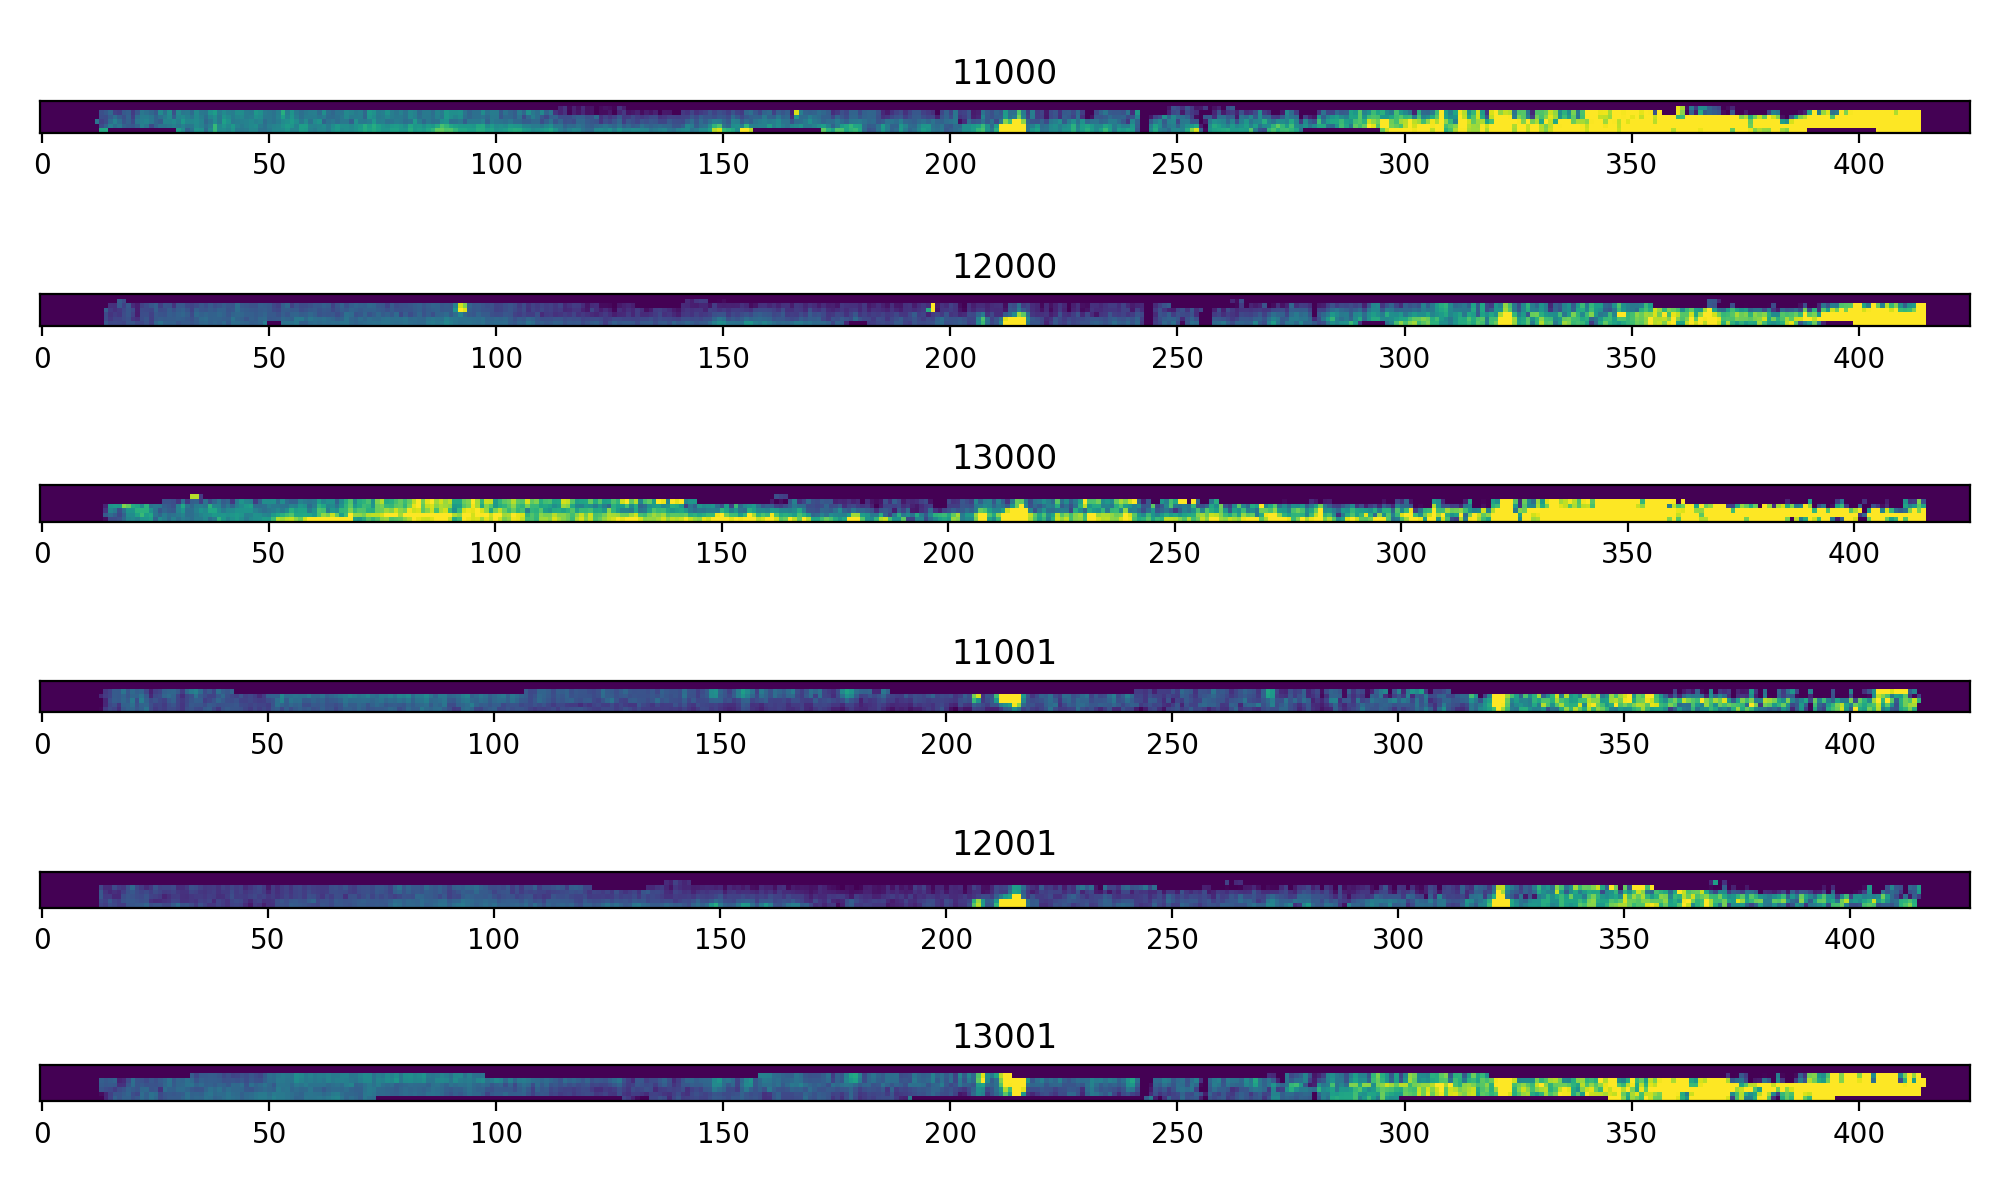

In [38]:
s2dfile_a = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s11000_s2d.fits')
with fits.open(s2dfile_a) as s2dhdu:
    s2dim_a = s2dhdu[1].data

s2dfile_b = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s12000_s2d.fits')
with fits.open(s2dfile_b) as s2dhdu:
    s2dim_b = s2dhdu[1].data

s2dfile_c = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s13000_s2d.fits')
with fits.open(s2dfile_c) as s2dhdu:
    s2dim_c = s2dhdu[1].data

s2dfile_d = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s11001_s2d.fits')
with fits.open(s2dfile_d) as s2dhdu:
    s2dim_d = s2dhdu[1].data

s2dfile_e = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s12001_s2d.fits')
with fits.open(s2dfile_e) as s2dhdu:
    s2dim_e = s2dhdu[1].data

s2dfile_f = os.path.join(input_path, 'L3_bgsub', 'WHL0137_Level3_AllMSA_BGSUB_s13001_s2d.fits')
with fits.open(s2dfile_f) as s2dhdu:
    s2dim_f = s2dhdu[1].data

fig, ax = plt.subplots(6,1,figsize=(10,6))

ax[0].imshow(s2dim_a, origin='lower', vmin=0, vmax=2e-13)
ax[0].set_yticks([])
ax[0].set_title('11000')

ax[1].imshow(s2dim_b, origin='lower', vmin=0, vmax=2e-13)
ax[1].set_yticks([])
ax[1].set_title('12000')

ax[2].imshow(s2dim_c, origin='lower', vmin=0, vmax=4e-13)
ax[2].set_yticks([])
ax[2].set_title('13000')

ax[3].imshow(s2dim_d, origin='lower', vmin=0, vmax=2e-13)
ax[3].set_yticks([])
ax[3].set_title('11001')

ax[4].imshow(s2dim_e, origin='lower', vmin=0, vmax=2e-13)
ax[4].set_yticks([])
ax[4].set_title('12001')

ax[5].imshow(s2dim_f, origin='lower', vmin=0, vmax=2e-13)
ax[5].set_yticks([])
ax[5].set_title('13001')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


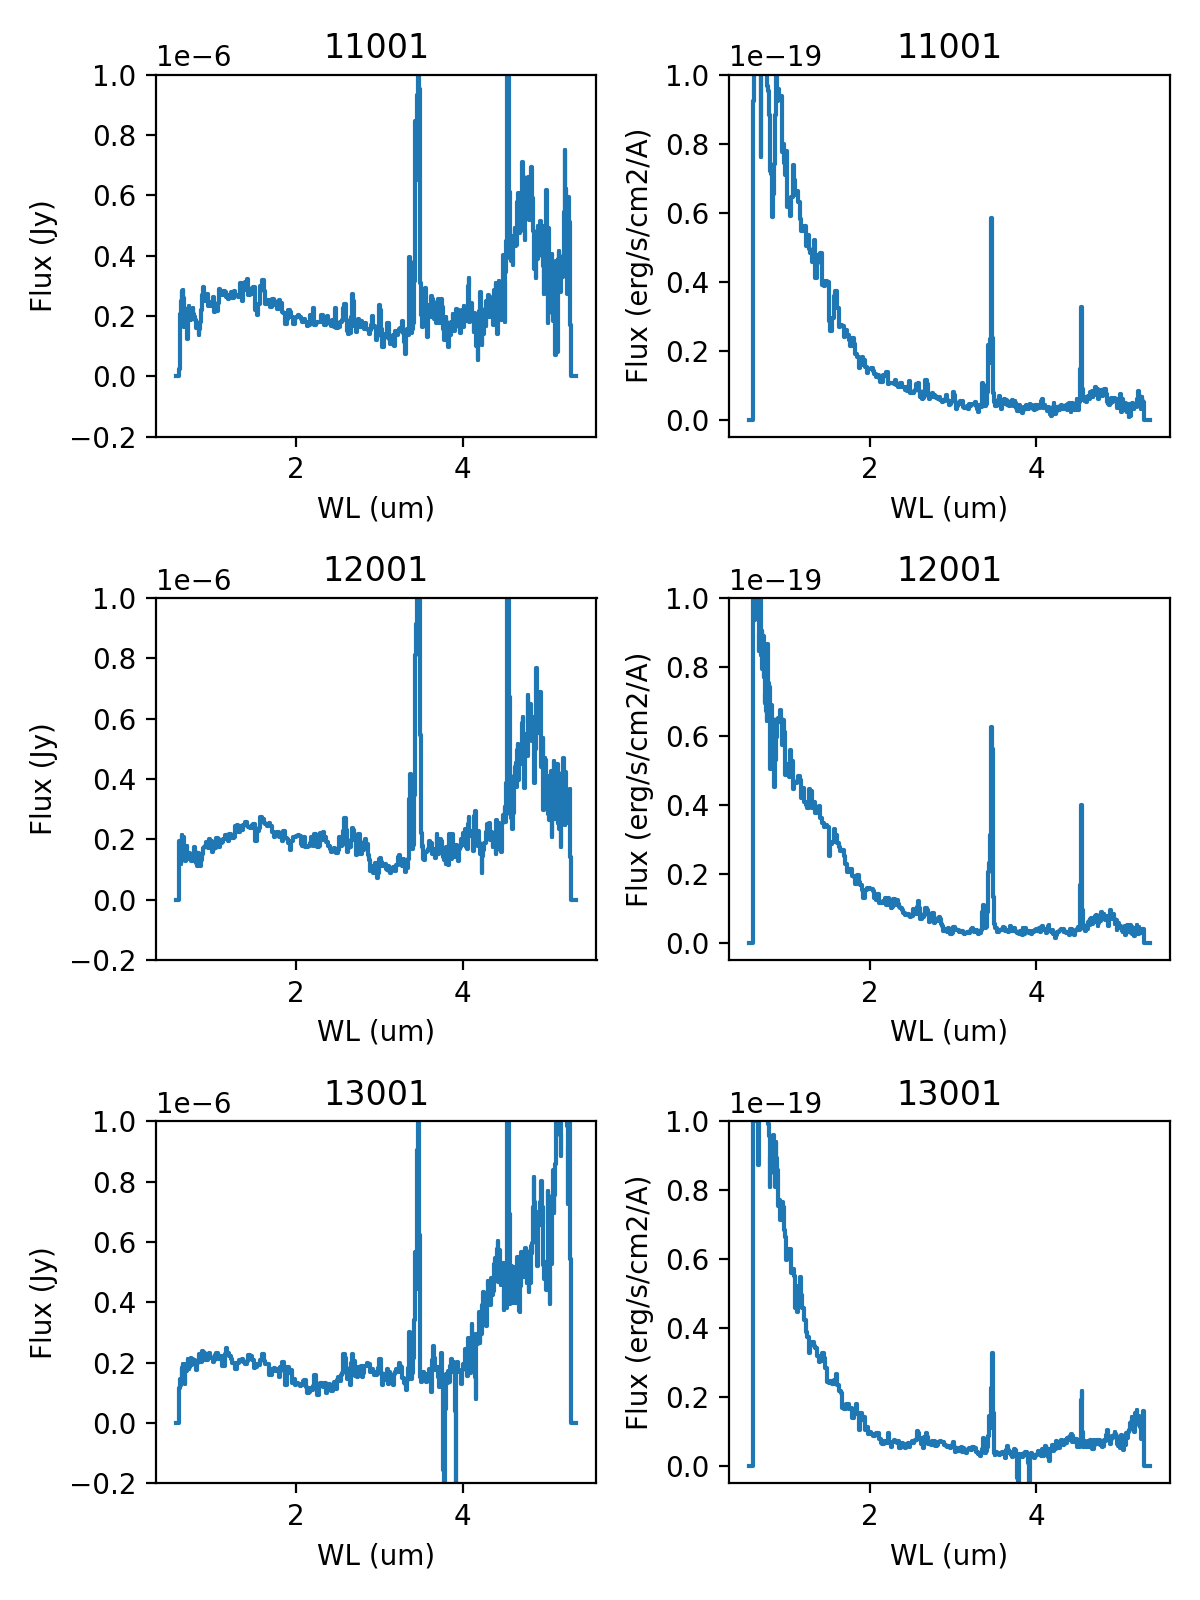

In [42]:
x1d11001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s11001_x1d.fits')
s2d11001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s11001_s2d.fits')
flux11001, err11001, wl11001 = extract1D(x1d11001, s2d11001, (0,4), None)

spec11001 = convert_to_cgs(flux11001, err11001, wl11001)

x1d12001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s12001_x1d.fits')
s2d12001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s12001_s2d.fits')
flux12001, err12001, wl12001 = extract1D(x1d12001, s2d12001, (0,4), None)

spec12001 = convert_to_cgs(flux12001, err12001, wl12001)

x1d13001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s13001_x1d.fits')
s2d13001 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s13001_s2d.fits')
flux13001, err13001, wl13001 = extract1D(x1d13001, s2d13001, (1,4), None)

spec13001 = convert_to_cgs(flux13001, err13001, wl13001)


fig, ax = plt.subplots(3,2, figsize=(6,8))


ax[0][0].step(wl11001, flux11001, where='mid')
ax[0][0].set_xlabel('WL (um)')
ax[0][0].set_ylabel('Flux (Jy)')
ax[0][0].set_ylim(-2e-7, 1e-6)
ax[0][0].set_title('11001')

ax[0][1].step(spec11001.spectral_axis, spec11001.flux, where='mid')
ax[0][1].set_ylim(-5e-21,1e-19)
ax[0][1].set_xlabel('WL (um)')
ax[0][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[0][1].set_title('11001')

ax[1][0].step(wl12001, flux12001, where='mid')
ax[1][0].set_xlabel('WL (um)')
ax[1][0].set_ylabel('Flux (Jy)')
ax[1][0].set_ylim(-2e-7, 1e-6)
ax[1][0].set_title('12001')

ax[1][1].step(spec12001.spectral_axis, spec12001.flux, where='mid')
ax[1][1].set_ylim(-5e-21,1e-19)
ax[1][1].set_xlabel('WL (um)')
ax[1][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[1][1].set_title('12001')

ax[2][0].step(wl13001, flux13001, where='mid')
ax[2][0].set_xlabel('WL (um)')
ax[2][0].set_ylabel('Flux (Jy)')
ax[2][0].set_ylim(-2e-7, 1e-6)
ax[2][0].set_title('13001')

ax[2][1].step(spec13001.spectral_axis, spec13001.flux, where='mid')
ax[2][1].set_ylim(-5e-21,1e-19)
ax[2][1].set_xlabel('WL (um)')
ax[2][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[2][1].set_title('13001')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


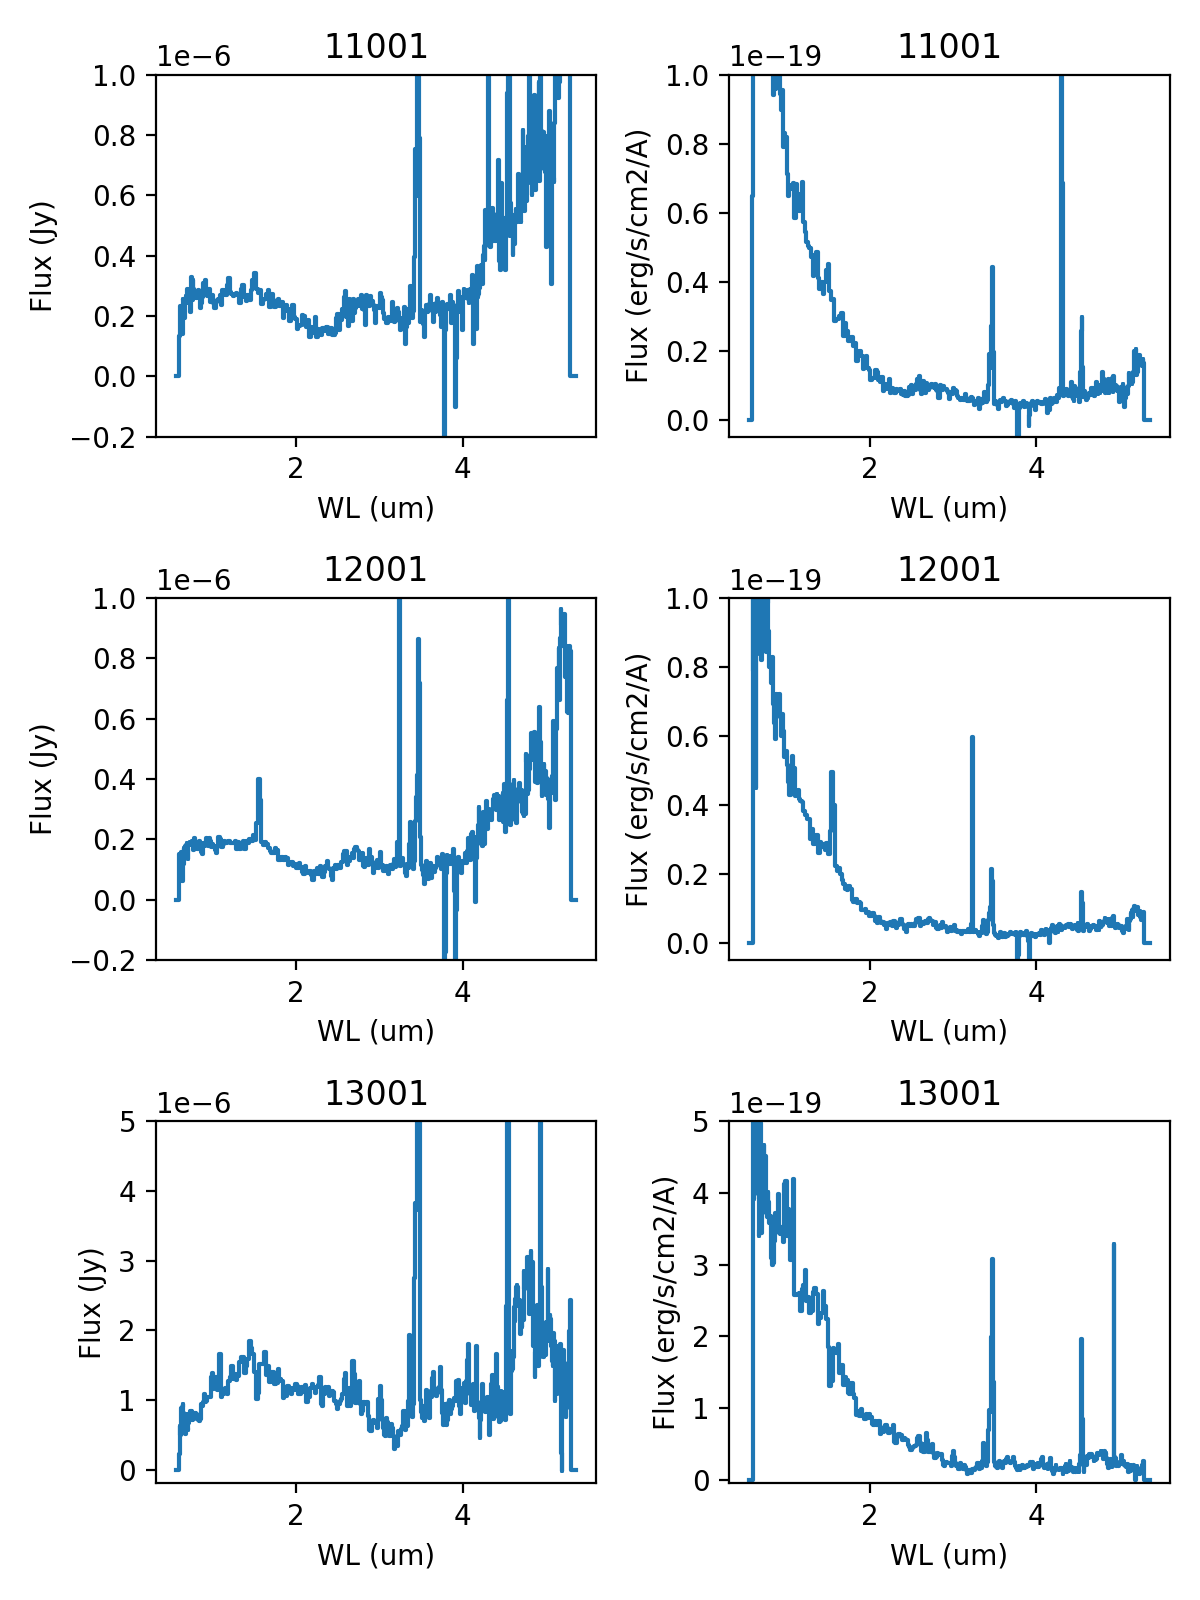

In [46]:
x1d11000 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s11000_x1d.fits')
s2d11000 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s11000_s2d.fits')
flux11000, err11000, wl11000 = extract1D(x1d11000, s2d11000, (1,4), None)

spec11000 = convert_to_cgs(flux11000, err11000, wl11000)

x1d12000 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s12000_x1d.fits')
s2d12000 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s12000_s2d.fits')
flux12000, err12000, wl12000 = extract1D(x1d12000, s2d12000, (1,4), None)

spec12000 = convert_to_cgs(flux12000, err12000, wl12000)

x1d13000 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s13000_x1d.fits')
s2d13000 = os.path.join(input_path, 'L3_bgsub/WHL0137_Level3_AllMSA_BGSUB_s13000_s2d.fits')
flux13000, err13000, wl13000 = extract1D(x1d13000, s2d13000, (0,4), None)

spec13000 = convert_to_cgs(flux13000, err13000, wl13000)


fig, ax = plt.subplots(3,2, figsize=(6,8))


ax[0][0].step(wl11000, flux11000, where='mid')
ax[0][0].set_xlabel('WL (um)')
ax[0][0].set_ylabel('Flux (Jy)')
ax[0][0].set_ylim(-2e-7, 1e-6)
ax[0][0].set_title('11001')

ax[0][1].step(spec11000.spectral_axis, spec11000.flux, where='mid')
ax[0][1].set_ylim(-5e-21,1e-19)
ax[0][1].set_xlabel('WL (um)')
ax[0][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[0][1].set_title('11001')

ax[1][0].step(wl12000, flux12000, where='mid')
ax[1][0].set_xlabel('WL (um)')
ax[1][0].set_ylabel('Flux (Jy)')
ax[1][0].set_ylim(-2e-7, 1e-6)
ax[1][0].set_title('12001')

ax[1][1].step(spec12000.spectral_axis, spec12000.flux, where='mid')
ax[1][1].set_ylim(-5e-21,1e-19)
ax[1][1].set_xlabel('WL (um)')
ax[1][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[1][1].set_title('12001')

ax[2][0].step(wl13000, flux13000, where='mid')
ax[2][0].set_xlabel('WL (um)')
ax[2][0].set_ylabel('Flux (Jy)')
ax[2][0].set_ylim(-2e-7, 5e-6)
ax[2][0].set_title('13001')

ax[2][1].step(spec13000.spectral_axis, spec13000.flux, where='mid')
ax[2][1].set_ylim(-5e-21,5e-19)
ax[2][1].set_xlabel('WL (um)')
ax[2][1].set_ylabel('Flux (erg/s/cm2/A)')
ax[2][1].set_title('13001')

plt.tight_layout()
plt.show()